# STIRAP2
### TODO:
 * add Louvillian op
 * add in realistic experimental parameters, i.e. insufficient blue Rabi frequency
 * for larger more gross hamiltonians (e.g. multi-atom rydberg blockade
 stuff), consider using either of the following:
   * generalized methods from stirap_symbolic.ipynb; may want to code in the RWA though... 
   * writing a function to spit out the rhs of the von neumann eqs using the general result for diagonal/off-diagonal terms for a given hamiltonian
 
### Conditions for STIRAP
 1. The mixing angle θ(t) of Eq. (12) varies slowly (adiabatically). 
 2. The P pulse is negligible at the start of the pulse sequence (|θ| → 0 mod π). 
 3. The S pulse is negligible at the termination of the pulse sequence (jθj → π∕2 mod π). 
 4. The two-photon detuning remains zero, i.e., δ = 0. 
 5. The single-photon detuning Δ is constant (optimally zero). 

In [1]:
%matplotlib inline

In [2]:
from numpy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
import time

from physconsts import *
from rbconsts import *
from amophys import cc

In [3]:
#### functions 

def derivs(y0,t,O1,O2,D1,D2):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    r11,r12,r13,r22,r23,r33 = y0
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

def runsim(func, idx=0, t_exp=60, tcentered=False):
    """ func is the derivs function
        idx is the index of the unraveled density matrix where 
            the population starts
        t_exp is experiment duration. t_2pi = 2*pi/w_rabi for 
            the simple three-level system
    """
    dt = 0.01 # timestep for DE solver
    t = arange(t_exp,step=dt)
    if tcentered == True:
        t -= t_exp/2
    tspan = [t[0],t[-1]]

    y0 = zeros(6, complex)
    y0[0] = 1 + 0j # all population in ground state rho11

    return solve_ivp(func,tspan,y0,t_eval=t)#linspace(0,t_exp,400))

# # the dressed states
# psi_1 = lambda

In [8]:
#### class for simulations

class AtomSim:
    """Atom internal dynamics simulation. 
       'rho0': unraveled density matrix, non-redundant elements only
       'derivs'
       't_exp'
    """
    
    def __init__(self, rho0, derivs, t_exp): 
        self.rho0 = rho0
        self.derivs = derivs
        self.t_exp = t_exp # duration
        self.t = arange(t_exp,step=dt) # the timesteps
        
        self.m = len(rho0) # number of non-redunant rho elements
        self.dim = int((-1 + sqrt(1 + 8*m))/2)
        self.idx_p, self.idx_c = self.rho_idx()
        
        self.populations = [] # values for each time step
        self.coherences = [] # values for each time step
        
    def runsim(self, idx=0, tcentered=False):
        dt = 0.01 # timestep for DE solver
        if tcentered == True:
            self.t -= t_exp/2
        tspan = [self.t[0],self.t[-1]]
        rho,t = solve_ivp(func,tspan,y0,t_eval=self.t)
        self.soln = rho
        
        for i in self.idx_p:
            self.populations.append(self.soln[i])
        for i in self.idx_c:
            self.coherences.append(self.soln[i])
        
        return self.soln, self.t
    
    def plots(self, show=['population, fields, coherences']):
        """ show plots for the items in 'show' 
        """
        # TODO: check if items listed in show correspond to non-empty
        # lists or arrays

        # refactor this -_-
        
        axes = []
        if len(show) == 1:
            fig, ax = plt.subplots()
            axes.append(ax)
        elif 'coherences' in show and 'populations' in show:
            fig, ax = plt.subplots()
            axes.append(ax)
        else: # the only way to have multiple subplots
            fig, axes = plt.subplots(1,2)
        
        def population_ax(ax):
            """ for both population and coherence plots """
            ax.set_title("Density matrix elements")
            ax.set_xlimit((self.t[0], self.t[-1]))
            return ax

        def fields_ax(ax):
            ax.set_title("Applied fields")
            ax.set_xlimit((self.t[0], self.t[-1]))
            return ax

        i = 0
        if 'population' in show or 'coherence' in show:
            axes.append(population_ax())
            if 'population' in show:
                for p,n in enumerate(soln.populations):
                    axes[i].plot(p, soln.t, label=f'rho_{n,n}')
            if 'coherence' in show:
                for c,n in zip(soln.coherences,self.idx_c):
                    # TODO: calculate m,n from self.idx_c
                    axes[i].plot(p, soln.t)#, label=f'rho_{m,n}')
        return fig
    
    def rho_idx(self): 
        """ for a N x N density matrix unraveled into a list of 
            non-redundant elements, return two lists, one which 
            contains the indices of the population terms, and 
            the other the indices of the coherence terms. 
        """        

#         if N == self.dim:
#             m = self.m
#         else: 
#             m = int(N*(N + 1)/2)
        N = self.dim

        idx_p = [0]# population indices
        idx_c = [] # coherence indices

        j = 0
        for i in range(1,m): # could probably put this in a recursive function
            if i == last + N - j:
                idx_p.append(i)
                last = i
                j += 1
            else:
                idx_c.append(i)

        return idx_p, idx_c

In [9]:
# last = 0
# m = 10
# N = 4
# idx_p = [0]# population indices
# idx_c = [] # coherence indices

# j = 0
# for i in range(1,m):
#     if i == last + N - j:
#         idx_p.append(i)
#         last = i
#         j += 1
#     else:
#         idx_c.append(i)
        
# idx_p, idx_c

([0, 4, 7, 9], [1, 2, 3, 5, 6, 8])

In [19]:
#### test the AtomSim class

rho0 = zeros(6, complex)
rho0[0] = 1 + 0j

w = 10
dt = 20
t_exp = 120
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

sim = AtomSim(rho0, func, t_exp)

UnboundLocalError: local variable 'last' referenced before assignment

In [5]:
#### parameters for coherent |g> <--> |r> oscillation 
# w = 1 # doesn't matter here
# t2 = 1 # doesn't matter here
# t1 = t2 + 5 # doesn't matter here
# O2 = lambda t: 2*pi*1 #exp(-((t-t2)/w)**2/2) # arb units
# O1 = lambda t: 2*pi*1 #exp(-((t-t1)/w)**2/2)
# D1 = 2*pi*10 # arb units
# D2 = lambda t: -D1# + (O1(t)**2 - O2(t)**2)/4*D1

#### parameters for stirap maybe
w = 10
dt = 20
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

In [6]:
# func = lambda y,t: derivs(t,y,O1(t),O2(t),D1,D2(t))
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

soln = runsim(func, t_exp=120, tcentered=True)

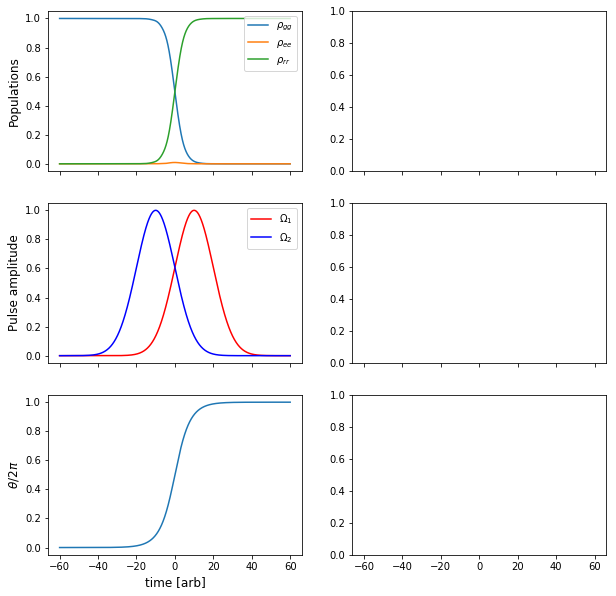

In [9]:
fig, ax = plt.subplots(3,2, figsize=(10,10), sharex=True)
fntsize = 12
unit = 1 #2*pi # divide

# populations -- interaction basis {|g>,|e>,|r>}
# ax[0][0].set_title('Population evolution w/o spontaneous emission')
ax[0][0].set_ylabel('Populations', size=fntsize)
for i,l in zip([0,3,5],[r'$\rho_{gg}$',r'$\rho_{ee}$',r'$\rho_{rr}$']):
    ax[0][0].plot(soln.t/unit,soln.y[i],label=l)
ax[0][0].legend(loc='upper right')

# rabi frequency
ax[1][0].set_ylabel('Pulse amplitude', size=fntsize)
ax[1][0].plot(soln.t,O1(soln.t)/Omax,c='r',label=r'$\Omega_1$')
ax[1][0].plot(soln.t,O2(soln.t)/Omax,c='b',label=r'$\Omega_2$')
ax[1][0].legend(loc='upper right')

# mixing angle
ax[2][0].set_ylabel(r'$\theta / 2\pi$', size=fntsize)
ax[2][0].plot(soln.t, arctan(O1(soln.t)/O2(soln.t))/(pi/2))
ax[2][0].set_xlabel('time [arb]', size=fntsize)

# populations in dressed basis {|B+>,|D>,|B->}
# coherences
# for i,l in zip([1,2],[r'$\rho_{ge}$', r'$\rho_{gr}$']): ## this isn't correct
#     ax[0][1].plot(soln.t,soln.y[i], label=l)
# ax[0][1].set_ylim((0,1))
# ax[0][1].legend(loc='upper right')

# plot population in ee vs single pulse area? 

plt.show()